In [1]:
import pandas
import datetime
import numpy
import scipy.optimize
from scipy.optimize import curve_fit
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import bs4
import urllib
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.ticker import FuncFormatter, MaxNLocator
import matplotlib.colors as colors
%matplotlib inline

In [2]:
# Some constants
cutOffMLTMLATUniqCnt = 4

In [3]:
# Asy Inds
asyDF = pandas.read_csv( "../data/Asy_processed.txt", sep=' ' )
asyDF["date"] = pandas.to_datetime(asyDF["datetimeStr"], format='%Y%m%d-%H-%M')
asyDF["hour"] = asyDF["date"].apply(lambda x: x.strftime('%H'))
asyDF["minute"] = asyDF["date"].apply(lambda x: x.strftime('%M'))
asyDF["dtStr"] = asyDF["date"].apply(lambda x: x.strftime('%Y%m%d'))
asyDF.head()

,datetimeStr,AsyD,AsyH,SymD,SymH,date,hour,minute,dtStr
0,20110101-00-00,17.0,13.0,1.0,-10.0,2011-01-01 00:00:00,00,00,20110101
1,20110101-00-01,17.0,13.0,1.0,-10.0,2011-01-01 00:01:00,00,01,20110101
2,20110101-00-02,17.0,13.0,1.0,-10.0,2011-01-01 00:02:00,00,02,20110101
3,20110101-00-03,17.0,13.0,1.0,-10.0,2011-01-01 00:03:00,00,03,20110101
4,20110101-00-04,17.0,13.0,1.0,-10.0,2011-01-01 00:04:00,00,04,20110101


In [4]:
velsDataDF = pandas.read_csv( "../data/processed-vels-geomag-fin.txt", sep=' ',\
                            infer_datetime_format=True,\
                            parse_dates=["date"])
# Get actual SAPS azimuths
velsDataDF["azim"] = -90.-velsDataDF["azim"]
velsDataDF.head()
# Filter out some values
# When there aren't good number of measurements at lats
# discard those values
cntMLTPntsDF = velsDataDF[ ["dst_bin", "normMLT", "MLAT"] \
                    ].groupby( ["dst_bin", "normMLT"] \
                    )["MLAT"].nunique().reset_index()
cntMLTPntsDF.columns = ["dst_bin", "normMLT", "MLATCntUnq"]
cntMLTPntsDF = cntMLTPntsDF[ cntMLTPntsDF["MLATCntUnq"] >=\
                    cutOffMLTMLATUniqCnt ][ ["dst_bin", "normMLT"]\
                        ].reset_index(drop=True)
velsDataDF = pandas.merge( velsDataDF, cntMLTPntsDF,\
                    on=["dst_bin", "normMLT"], how="inner" )
velsDataDF["hour"] = velsDataDF["date"].apply(lambda x: x.strftime('%H'))
velsDataDF["minute"] = velsDataDF["date"].apply(lambda x: x.strftime('%M'))
velsDataDF["dtStr"] = velsDataDF["date"].apply(lambda x: x.strftime('%Y%m%d'))

In [5]:
# Also merge with aymDF
# print "pre merge shape-->", velsDataDF.shape
velsDataDF = pandas.merge( velsDataDF, asyDF,\
                         on=["dtStr", "hour", "minute"], how='inner')
velsDataDF = velsDataDF [ ['azim','azimStd', 'delMLT', 'goodFit',\
                      'MLAT', 'normMLT', 'vSaps', 'velSTD',\
                      'endPtMLAT', 'endPtNormMLT', 'date_x','dtStr',\
                      'hour', 'minute', 'dst_date', 'dst_index', 'dst_bin',\
                      'datetimeStr_x', 'AE', 'AL', 'AO', 'AU', 'count', 'maxCount',\
                       'probOcc', 'AsyD', 'AsyH', 'SymD', 'SymH'] ]
velsDataDF.columns = ['azim','azimStd', 'delMLT', 'goodFit',\
                      'MLAT', 'normMLT', 'vSaps', 'velSTD',\
                      'endPtMLAT', 'endPtNormMLT', 'date','dtStr',\
                      'hour', 'minute', 'dst_date', 'dst_index', 'dst_bin',\
                      'datetimeStr', 'AE', 'AL', 'AO', 'AU', 'count', 'maxCount',\
                       'probOcc', 'AsyD', 'AsyH', 'SymD', 'SymH']

In [6]:
# Divide asymH index into bins
asyHBins = [ 0, 30, 60, 90, 180 ]
velsDataDF = pandas.concat( [ velsDataDF, \
                    pandas.cut( velsDataDF["AsyH"], \
                               bins=asyHBins ) ], axis=1 )
velsDataDF.columns = ['azim','azimStd', 'delMLT', 'goodFit',\
                      'MLAT', 'normMLT', 'vSaps', 'velSTD',\
                      'endPtMLAT', 'endPtNormMLT', 'date','dtStr',\
                      'hour', 'minute', 'dst_date', 'dst_index', 'dst_bin',\
                      'datetimeStr', 'AE', 'AL', 'AO', 'AU', 'count', 'maxCount',\
                       'probOcc', 'AsyD', 'AsyH', 'SymD', 'SymH', 'AsyH_bin']

In [7]:
mltAzimsVarsDF = velsDataDF[ ["normMLT", "AsyH_bin", "azim"] \
                    ].groupby( ["normMLT", "AsyH_bin"] ).mean().reset_index()
mltAzimsVarsDF.columns = ["normMLT", "AsyH_bin", "mean_azim"]
stdAzimsVarsDF = velsDataDF[ ["normMLT", "AsyH_bin", "azim"] \
                    ].groupby( ["normMLT", "AsyH_bin"] ).std().reset_index()
stdAzimsVarsDF.columns = ["normMLT", "AsyH_bin", "std_azim"]
mltAzimsVarsDF = pandas.merge( mltAzimsVarsDF, stdAzimsVarsDF, on=["normMLT", "AsyH_bin"] )
mltAzimsVarsDF = mltAzimsVarsDF[ mltAzimsVarsDF["normMLT"] <= 2 ]
mltAzimsVarsDF = mltAzimsVarsDF.round(2)

In [8]:
mltAzimsVarsDF["AsyH_bin"] = mltAzimsVarsDF["AsyH_bin"].astype(str)

In [9]:
def linear_func(x, slope, intrcpt):
    # we are working in degrees but numpy deals with radians
    # convert to radians
    return intrcpt + slope*x

fitDFAsyH30 = mltAzimsVarsDF[ mltAzimsVarsDF[ "AsyH_bin" ] == "(0, 30]" ].dropna()
fitDFAsyH60 = mltAzimsVarsDF[ mltAzimsVarsDF[ "AsyH_bin" ] == "(30, 60]" ].dropna()
fitDFAsyH90 = mltAzimsVarsDF[ mltAzimsVarsDF[ "AsyH_bin" ] == "(60, 90]" ].dropna()
fitDFAsyH180 = mltAzimsVarsDF[ mltAzimsVarsDF[ "AsyH_bin" ] == "(90, 180]" ].dropna()
print fitDFAsyH30
slope30, intercept30, r_value30,\
    p_value30, std_err30 = linregress(\
                fitDFAsyH30['normMLT'].T,fitDFAsyH30['mean_azim'].T )
popt30 = []
popt30.append( slope30 )
popt30.append( intercept30 )

print "AsyH 30-->", slope30, intercept30, r_value30, p_value30, std_err30

slope60, intercept60, r_value60,\
    p_value60, std_err60 = linregress(\
                fitDFAsyH60['normMLT'].T,fitDFAsyH60['mean_azim'].T )
popt60 = []
popt60.append( slope60 )
popt60.append( intercept60 )

print "AsyH 60-->", slope60, intercept60, r_value60, p_value60, std_err60


slope90, intercept90, r_value90,\
    p_value90, std_err90 = linregress(\
                fitDFAsyH90['normMLT'].T,fitDFAsyH90['mean_azim'].T )
popt90 = []
popt90.append( slope90 )
popt90.append( intercept90 )


print "AsyH 90-->", slope90, intercept90, r_value90, p_value90, std_err90

slope180, intercept180, r_value180,\
    p_value180, std_err180 = linregress(\
                fitDFAsyH180['normMLT'].T,fitDFAsyH180['mean_azim'].T )
popt180 = []
popt180.append( slope180 )
popt180.append( intercept180 )


print "AsyH 180-->", slope180, intercept180, r_value180, p_value180, std_err180


# Now get data from the fits
normMLTModel30 = range( int( numpy.min(fitDFAsyH30['normMLT']) ), int( numpy.max(fitDFAsyH30['normMLT']) ) + 1, 1)
velArrModel30 = [ round( linear_func(t, popt30[0], popt30[1]), 2 ) for t in normMLTModel30 ]

normMLTModel60 = range( int( numpy.min(fitDFAsyH60['normMLT']) ), int( numpy.max(fitDFAsyH60['normMLT']) ) + 1, 1)
velArrModel60 = [ round( linear_func(t, popt60[0], popt60[1]), 2 ) for t in normMLTModel60 ]

normMLTModel90 = range( int( numpy.min(fitDFAsyH90['normMLT']) ), int( numpy.max(fitDFAsyH90['normMLT']) ) + 1, 1)
velArrModel90 = [ round( linear_func(t, popt90[0], popt90[1]), 2 ) for t in normMLTModel90 ]

normMLTModel180 = range( int( numpy.min(fitDFAsyH180['normMLT']) ), int( numpy.max(fitDFAsyH180['normMLT']) ) + 1, 1)
velArrModel180 = [ round( linear_func(t, popt180[0], popt180[1]), 2 ) for t in normMLTModel180 ]


    normMLT AsyH_bin  mean_azim  std_azim
0      -7.0  (0, 30]     -85.48      2.28
4      -6.0  (0, 30]     -82.12      6.02
8      -5.0  (0, 30]     -82.01      5.14
12     -4.0  (0, 30]     -82.91      6.29
16     -3.0  (0, 30]     -83.09      6.63
20     -2.0  (0, 30]     -83.78      7.60
24     -1.0  (0, 30]     -84.64      8.99
28      0.0  (0, 30]     -84.94     10.23
32      1.0  (0, 30]     -84.77     10.68
36      2.0  (0, 30]     -85.64     11.76
AsyH 30--> -0.245575757576 -84.5519393939 -0.552707195312 0.0975251454132 0.130914008045
AsyH 60--> -0.960424242424 -88.1020606061 -0.995172614247 2.36215307423e-09 0.0334862059234
AsyH 90--> -1.20248484848 -90.0852121212 -0.943433438668 4.18242178006e-05 0.149412894489
AsyH 180--> -2.37278787879 -94.426969697 -0.985777942272 1.7595294793e-07 0.143014932405


In [10]:
strAzim30 = "Azim = " + str( round( popt30[1],2 )  ) + " + (" + str( round( popt30[0],2 ) )  + ") x $\Delta MLT_{00}$"
strAzim60 = "Azim = " + str(  round( popt60[1],2  ) ) + " + (" + str( round( popt60[0],2 ) )  + ") x $\Delta MLT_{00}$"
strAzim90 = "Azim = " + str(  round( popt90[1],2  ) ) + " + (" + str( round( popt90[0],2 ) )  + ") x $\Delta MLT_{00}$"
strAzim180 = "Azim = " + str(  round( popt180[1],2  ) ) + " + (" + str( round( popt180[0],2 ) )  + ") x $\Delta MLT_{00}$"

In [11]:
def format_mlt_normMLT_ticks(tick_val, tick_pos):
    if tick_val < 0:
        return str(tick_val + 24)
    else:
        return str(tick_val)

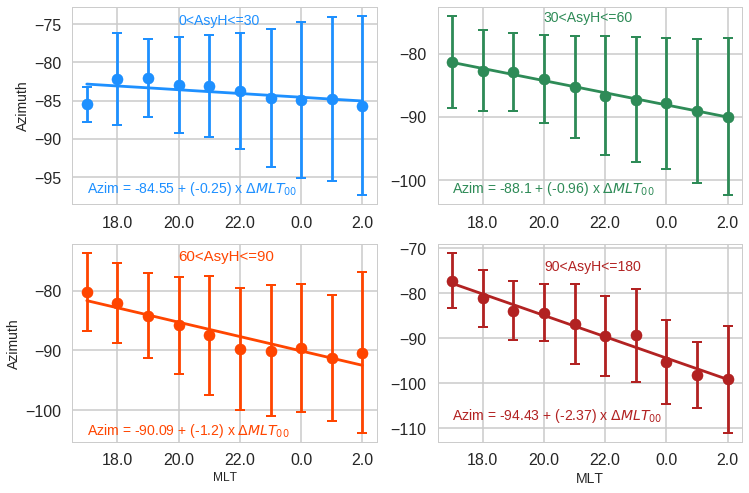

In [12]:
sns.set_style("whitegrid")
sns.set_context("poster")

f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(2,2,1)
ax2 = f.add_subplot(2,2,2)
ax3 = f.add_subplot(2,2,3)
ax4 = f.add_subplot(2,2,4)

mltAzimsVarsDF = mltAzimsVarsDF.sort_values(["normMLT"])
unqNrmMLTList = sorted( mltAzimsVarsDF["normMLT"].unique().tolist() )
mltStr = []
for j in unqNrmMLTList:
    if j < 0:
        mltStr.append( str(int(j + 24)) )
    else:
        mltStr.append( str(int(j)) )
###### PLOT AsyH_bin (0, 30] ######
###### PLOT AsyH_bin (0, 30] ######
###### PLOT AsyH_bin (0, 30] ######

ax1.scatter(mltAzimsVarsDF['normMLT'][mltAzimsVarsDF['AsyH_bin'] == "(0, 30]"],
            mltAzimsVarsDF['mean_azim'][mltAzimsVarsDF['AsyH_bin'] == "(0, 30]"],
            marker='o',
            color='dodgerblue',
            alpha=0.7,
            s = 124,
            label='(0, 30]')
ax1.errorbar(mltAzimsVarsDF['normMLT'][mltAzimsVarsDF['AsyH_bin'] == "(0, 30]"],\
             mltAzimsVarsDF['mean_azim'][mltAzimsVarsDF['AsyH_bin'] == "(0, 30]"],\
             yerr=mltAzimsVarsDF['std_azim'][mltAzimsVarsDF['AsyH_bin'] == "(0, 30]"], \
             color='dodgerblue', label='', capthick=2., capsize=5., fmt='o')
ax1.plot( normMLTModel30, velArrModel30, color='dodgerblue' )

ax1.xaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks)) 
ax1.text(-4., -75., "0<AsyH<=30", fontsize=14, color='dodgerblue') 

###### PLOT AsyH_bin (0, 30] ######
###### PLOT AsyH_bin (0, 30] ######
###### PLOT AsyH_bin (0, 30] ######


###### PLOT AsyH_bin (30, 60] ######
###### PLOT AsyH_bin (30, 60] ######
###### PLOT AsyH_bin (30, 60] ######

ax2.scatter(mltAzimsVarsDF['normMLT'][mltAzimsVarsDF['AsyH_bin'] == "(30, 60]"],
            mltAzimsVarsDF['mean_azim'][mltAzimsVarsDF['AsyH_bin'] == "(30, 60]"],
            marker='o',
            color='seagreen',
            alpha=0.7,
            s = 124,
            label='(30, 60]')
ax2.errorbar(mltAzimsVarsDF['normMLT'][mltAzimsVarsDF['AsyH_bin'] == "(30, 60]"],\
             mltAzimsVarsDF['mean_azim'][mltAzimsVarsDF['AsyH_bin'] == "(30, 60]"],\
             yerr=mltAzimsVarsDF['std_azim'][mltAzimsVarsDF['AsyH_bin'] == "(30, 60]"], \
             color='seagreen', label='', capthick=2., capsize=5., fmt='o')

ax2.plot( normMLTModel60, velArrModel60, color='seagreen' )

ax2.xaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks)) 
ax2.text(-4., -75., "30<AsyH<=60", fontsize=14, color='seagreen') 

###### PLOT AsyH_bin (30, 60] ######
###### PLOT AsyH_bin (30, 60] ######
###### PLOT AsyH_bin (30, 60] ######


###### PLOT AsyH_bin (60, 90] ######
###### PLOT AsyH_bin (60, 90] ######
###### PLOT AsyH_bin (60, 90] ######

ax3.scatter(mltAzimsVarsDF['normMLT'][mltAzimsVarsDF['AsyH_bin'] == "(60, 90]"],
            mltAzimsVarsDF['mean_azim'][mltAzimsVarsDF['AsyH_bin'] == "(60, 90]"],
            marker='o',
            color='orangered',
            alpha=0.7,
            s = 124,
            label='(60, 90]')
ax3.errorbar(mltAzimsVarsDF['normMLT'][mltAzimsVarsDF['AsyH_bin'] == "(60, 90]"],\
             mltAzimsVarsDF['mean_azim'][mltAzimsVarsDF['AsyH_bin'] == "(60, 90]"],\
             yerr=mltAzimsVarsDF['std_azim'][mltAzimsVarsDF['AsyH_bin'] == "(60, 90]"], \
             color='orangered', label='', capthick=2., capsize=5., fmt='o')

ax3.plot( normMLTModel90, velArrModel90, color='orangered' )

ax3.xaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks))
ax3.text(-4., -75., "60<AsyH<=90", fontsize=15, color='orangered') 

###### PLOT AsyH_bin (60, 90] ######
###### PLOT AsyH_bin (60, 90] ######
###### PLOT AsyH_bin (60, 90] ######


ax4.scatter(mltAzimsVarsDF['normMLT'][mltAzimsVarsDF['AsyH_bin'] == "(90, 180]"],
            mltAzimsVarsDF['mean_azim'][mltAzimsVarsDF['AsyH_bin'] == "(90, 180]"],
            marker='o',
            color='firebrick',
            alpha=0.7,
            s = 124,
            label='(90, 180]')
ax4.errorbar(mltAzimsVarsDF['normMLT'][mltAzimsVarsDF['AsyH_bin'] == "(90, 180]"],\
             mltAzimsVarsDF['mean_azim'][mltAzimsVarsDF['AsyH_bin'] == "(90, 180]"],\
             yerr=mltAzimsVarsDF['std_azim'][mltAzimsVarsDF['AsyH_bin'] == "(90, 180]"], \
             color='firebrick', label='', capthick=2., capsize=5., fmt='o')

ax4.plot( normMLTModel180, velArrModel180, color='firebrick' )

ax4.xaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks))   
ax4.text(-4., -75., "90<AsyH<=180", fontsize=14, color='firebrick')


ax4.text(-7., -108., strAzim180, fontsize=14, color='firebrick')
ax3.text(-7., -104., strAzim90, fontsize=14, color='orangered')
ax2.text(-7., -102., strAzim60, fontsize=14, color='seagreen')
ax1.text(-7., -97., strAzim30, fontsize=14, color='dodgerblue')


# ax1.set_xlabel("MLT", fontsize=12)
ax1.set_ylabel("Azimuth", fontsize=14)
# ax2.set_xlabel("MLT", fontsize=14)
# ax2.set_ylabel("Azimuth", fontsize=12)
ax3.set_xlabel("MLT", fontsize=12)
ax3.set_ylabel("Azimuth", fontsize=14)
ax4.set_xlabel("MLT", fontsize=14)
# ax4.set_ylabel("Azimuth", fontsize=12)


plt.savefig("../figs/Azim-MLT-Asy.eps",bbox_inches='tight')

In [13]:
colList =[colors.rgb2hex(x) for x in sns.color_palette("Spectral_r",4)]
print colList
print sns.color_palette("Spectral",4)

[u'#66c2a5', u'#e6f598', u'#fee08b', u'#f46d43']
[(0.9568627450980393, 0.42745098039215684, 0.2627450980392157), (0.996078431372549, 0.8784313725490196, 0.5450980392156862), (0.9019607843137256, 0.9607843137254902, 0.5960784313725491), (0.4, 0.7607843137254902, 0.6470588235294118)]


In [14]:
print normMLTModel180, velArrModel180

[-7, -6, -5, -4, -3, -2, -1, 0, 1, 2] [-77.82, -80.19, -82.56, -84.94, -87.31, -89.68, -92.05, -94.43, -96.8, -99.17]
